# Trabalho de Aprendizado de Máquina 
---
## Disciplina: Inteligência Artificial - PCI
### **Professora: Dra. Aline Paes**
### **Alunos:**
*   **Régis Antônio Saraiva Albuquerque**
*   **Wilker Luiz Gadelha Maia**

# Relatório de Experimentos com Algoritmos de Aprendizado de Máquina

# Introdução

Este relatório apresenta experimentos com algoritmos de redes neurais existentes na plataforma scikit-learn. Foram realizados treinamentos e testes utilizando uma base de dados de classificação textual, a fim de observar métricas de acurácia, precisão, recall (revocação) e F1-Score. Antes da realização dos testes foram realizadas limpezas e normalizações na base. Foram utilizadas duas técnicas de representação textual nos experimentos: bag of words e representação vetorial densa. Por fim, foram feitas experimentações nas alterações de hiperparâmetros. 

# Metodologia experimental

Para a experimentação foi utilizado a linguagem Python 3 com a biblioteca open source de aprendizado de máquina Scikit-learn (https://scikit-learn.org/stable/). Todos os testes foram realizados no computador com a seguinte configuração: processador Intel Corei7-9750H de 2.60GHz, 15,5 GiB de memória RAM, 64 bits, placa de vídeo GeForce GTX 1660 Ti Mobile e Internet com velocidade de 300Mbps. O sistema operacional utilizado para os testes foi a distribuição GNU/Linux Ubuntu 22.04.1 LTS (Jammy Jellyfish).

## Os passos realizados foram:

1. Escolha da base de dados de classificação textual em PT-BR
2. Estudo da base de dados e preparação da base
3. Limpeza e normalização
4. Escolha do classificador de redes neurais
5. Divisão de Treino e Teste 
6. Validação Cruzada
7. Utilização de métricas de teste (descritas na próxima seção)
8. Experimentação utilizando técnica de bag of words
9. Experimentações nas alterações de hiperparâmetros
10. Experimentação utilizando técnica de representação vetorial densa


## Métricas de Teste

**Acurácia**: Mede o quão frequente um classificador está correto?

```
Acurácia = quantidade de acerto / (quantidade de acertos - quantidade de erros)
```

**Matriz de Confusão**: Consiste em uma tabela que permite visualizar o desempenho de um algoritmo de classificação. As linhas da matriz representam instâncias de uma classe prevista enquanto as colunas representa instâncias da classe atual. Ela permite fazermos uma análise mais detalhada da situação do nosso classificador uma vez que ela distingue nossos resultados em quatro classes. Para um problema relacionado a identificação se determinado e-mail é spam ou não:

```
*   Verdadeiros Positivos(True positive): casos em que retornamos a classe SPAM e o e-mail realmente era de spam.
*   Falsos positivos(False positives): casos em que retornamos a classe SPAM e na verdade eram e-mails comuns.
*   Falsos Verdadeiros (True Negative): casos que retornamos que era e-mail comum (ausência de spam) e realmente eram.
*   Falsos Negativos (False Negative): retornamos que não eram spam e na verdade eram spam.

```

**Precisão**: De todas as classificações de classe Positivo que o modelo fez, quantas estão corretas? A fórmula é dada por:

```
Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivo)
```

**Recall (Revocação)**: Entre todas as amostras que realmente eram de uma classe, qual a proporção classificada como da classe. A fórmula é dada por:

```
Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
```

**F1-Score**: Consiste na média harmônica entre precisão e recall. Esta medida une precisão e recall em apenas uma medida.

```
F1 = 2 * precisão * recall / (precisão + recall)
```

# Descrição da base e Análise Exploratório 


A base de dados foi escolhida do conjunto de bases presente nesta url: https://forum.ailab.unb.br/t/datasets-em-portugues/251;

Base Escolhida: B2W-Reviews01
```
B2W-Reviews01 é um corpus aberto de reviews de produtos. Ele contém mais de 130 mil avaliações de clientes de comércio eletrônico, coletadas no site da Americanas.com entre janeiro e maio de 2018. O B2W-Reviews01 oferece informações valiosas sobre o perfil do avaliador, como sexo, idade e localização geográfica (Link: https://github.com/americanas-tech/b2w-reviews01). 
```

Como podemos ver a base é composta por **132.373 registros** com **14 colunas**
```
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 14.1+ MB
```




In [1]:
# Importar as Bibliotecas 

import pandas as pd
import spacy
# import nltk
import string
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt import Portuguese

# pip install -U scikit-learn scipy matplotlib
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

# https://fasttext.cc/docs/en/python-module.html
# pip install fasttext
import fasttext
# https://fasttext.cc/docs/en/crawl-vectors.html
import fasttext.util

In [2]:
# DATASET: https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv

df = pd.read_csv('https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv', dtype={'product_id': str, 'review_text': str})

# Imprimir parte do DataSet para entendimento
#print("Quantidade de Linhas: ", len(df.index))
#df.head(5)
# print (df.shape)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


# Preparação da base de dados

## Nosso principal interesse é a coluna review_text e recommend_to_a_friend. Vamos remover todas as linhas que não possuem review e recommend_to_a_friend.

In [3]:
print(df['review_text'].isnull().sum(),df['recommend_to_a_friend'].isnull().sum())

3275 18


In [4]:
# Remover linhas que tenham texto nulo
df.dropna(subset=['review_text'], inplace=True)
df.dropna(subset=['recommend_to_a_friend'], inplace=True)

In [5]:
print(df['review_text'].isnull().sum(),df['recommend_to_a_friend'].isnull().sum())

0 0


### Agora vamos remover as colunas desnecessárias

In [6]:
# focar no texto e ignorar as demais colunas
comp_df = df[['review_text','recommend_to_a_friend']]
comp_df.columns =['text','label']
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129080 entries, 0 to 132372
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    129080 non-null  object
 1   label   129080 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


Yes    95066
No     34014
Name: label, dtype: int64


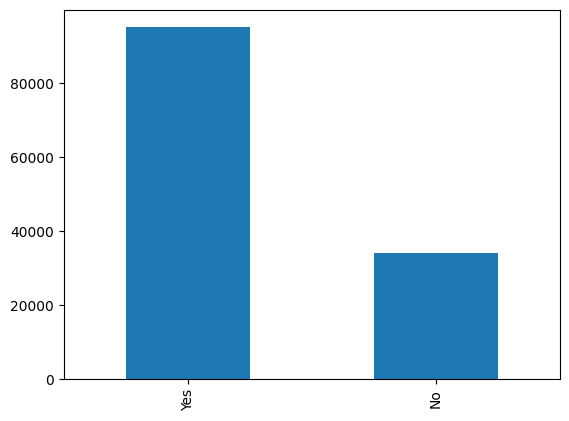

In [7]:
comp_df['label'].value_counts().plot.bar()
print(comp_df['label'].value_counts())

In [8]:
# Transformar o rótulo para númerico

comp_df['label'] = comp_df.label.replace('Yes', 1)
comp_df['label'] = comp_df.label.replace('No',2)

/tmp/ipykernel_18136/1256219312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['label'] = comp_df.label.replace('Yes', 1)
/tmp/ipykernel_18136/1256219312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['label'] = comp_df.label.replace('No',2)


In [9]:
comp_df.head()

,text,label
0,Estou contente com a compra entrega rápida o ú...,1
1,"Por apenas R$1994.20,eu consegui comprar esse ...",1
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1
4,"A entrega foi no prazo, as americanas estão de...",1


### A seguir é feito a limpeza da base, removendo caracteres especiais com expressões regulares. Experimentar diferentes estratégias de normalização (pré-processamento) (p.ex., remoção de stop-words, lematização, etc).  impeza e normalização 

In [10]:
#Remove @ tags
comp_df.text = comp_df.text.str.replace(r'(@\w*)',"USER")

#Remove URL
comp_df.text = comp_df.text.str.replace(r"http\S+", "HTTP")

#Remove # tag
comp_df.text = comp_df.text.str.replace(r'#+',"")


#Remove all non-character
#comp_df.text = comp_df.text.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
comp_df.text = comp_df.text.str.replace(r'( +)'," ")
comp_df.text = comp_df.text.str.strip()

# Remove números
comp_df.text = comp_df.text.str.replace('\d+', '')

# Change to lowercase
comp_df.text = comp_df.text.str.lower()

/tmp/ipykernel_18136/3603383595.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  comp_df.text = comp_df.text.str.replace(r'(@\w*)',"USER")
/tmp/ipykernel_18136/3603383595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.text = comp_df.text.str.replace(r'(@\w*)',"USER")
/tmp/ipykernel_18136/3603383595.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  comp_df.text = comp_df.text.str.replace(r"http\S+", "HTTP")
/tmp/ipykernel_18136/3603383595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [11]:
comp_df.head(20)

,text,label
0,estou contente com a compra entrega rápida o ú...,1
1,"por apenas r$.,eu consegui comprar esse lindo ...",1
2,supera em agilidade e praticidade outras panel...,1
3,meu filho amou! parece de verdade com tantos d...,1
4,"a entrega foi no prazo, as americanas estão de...",1
5,"excelente produto, por fora em material acríli...",1
6,"produto mto bom, com essa garrafinha vc pode a...",1
7,produto excelente qualidade boa câmera desenvo...,1
8,o barulho e minimo e o vento é bem forte na ve...,1
9,meu produto nao foi entregue e a americanas es...,2


In [12]:
!python -m spacy download pt

!python -m spacy download pt_core_news_lg

/bin/bash: line 1: python: command not found
/bin/bash: line 1: python: command not found


In [13]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("pt_core_news_sm") 
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

#parser = English()


# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    #mytokens = nlp(sentence)
    #print(mytokens)
    #for word in mytokens:
    #  print(word.lemma_)

    # Lemmatizing each token and converting each token into lowercase
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    #print(mytokens)
    #mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    #print(mytokens)

    # return preprocessed list of tokens
    return mytokens

In [24]:
teste_tk = comp_df.head(5000).copy()
teste_tk['corpus'] = [spacy_tokenizer(text) for text in teste_tk.text]
teste_tk.head()

,text,label,corpus
0,estou contente com a compra entrega rápida o ú...,1,"[contente, compra, entregar, rápido, único, pr..."
1,"por apenas r$.,eu consegui comprar esse lindo ...",1,"[r$, .,eu, conseguir, comprar, lindo, copo, ac..."
2,supera em agilidade e praticidade outras panel...,1,"[superar, agilidade, praticidade, outro, panel..."
3,meu filho amou! parece de verdade com tantos d...,1,"[filho, amar, parecer, verdade, detalhe]"
4,"a entrega foi no prazo, as americanas estão de...",1,"[entrega, em o, prazo, americana, parabéns, sm..."


In [25]:
teste = teste_tk.copy() 
teste.corpus = teste.apply(lambda x: " ".join(x.corpus),axis=1)
teste.head()

,text,label,corpus
0,estou contente com a compra entrega rápida o ú...,1,contente compra entregar rápido único problema...
1,"por apenas r$.,eu consegui comprar esse lindo ...",1,"r$ .,eu conseguir comprar lindo copo acrílico"
2,supera em agilidade e praticidade outras panel...,1,superar agilidade praticidade outro panela elé...
3,meu filho amou! parece de verdade com tantos d...,1,filho amar parecer verdade detalhe
4,"a entrega foi no prazo, as americanas estão de...",1,entrega em o prazo americana parabéns smart tv...



# Experimentações

# Experimentação utilizando técnica de bag of words

In [ ]:
X = teste.corpus.values
Y = teste.label.values

freq_vector = CountVectorizer(min_df=5, ngram_range=(1,2),stop_words='english').fit(teste.corpus)

X = freq_vector.transform(X)


print(X.shape)

## Treino e Teste Split

## Utilizamos o classificador MLPClassifier (Multi-layer Perceptron classifier.)

Semelhante à regressão logística, só que com mais camadas ocultas além das de entradas e saídas. Este classificador ajuda na solução de problemas não linearmente separáveis


https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=8)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, Y_train)


#y_pred_train=clf.predict(x_train)
#precision_recall_fscore_support(y_train, y_pred_train, average='macro')

Y_pred=clf.predict(X_test)
result = clf.score(X_test, Y_test)
print("Acurácia: ", result*100.0)
print(precision_recall_fscore_support(Y_test, Y_pred, average='macro'))

## Validação Cruzada K-Fold

In [ ]:
kfold = KFold(n_splits=10, shuffle=False, random_state=None)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

results = cross_val_score(clf, X, Y, cv=kfold)

print("Acurácia: ", results.mean()*100.0, results.std()*100.0)

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, Y_pred)
def plot_cm(conf_matrix):
  sns.set(font_scale=1.4,color_codes=True,palette="deep")
  sns.heatmap(cm,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
plot_cm(cm)

# Experimentar com ao menos duas alterações de hiperparâmetros (tipo da ativação, alteração na arquitetura, otimizador, ajuste da taxa de aprendizado, ajustar ou não a taxa de aprendizado, etc).

In [ ]:
cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), x_train, y_train, cv=10, verbose=1, n_jobs=-1).mean()

In [ ]:
params = {
    #'solver':['lbfgs', 'sgd', 'adam'],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001,0.01,0.1]
}

lr_grid = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1),params, cv=5, verbose=2, n_jobs=-1)
lr_grid.fit(X_train, Y_train)

Y_predict=lr_grid.predict(X_test)
cm=confusion_matrix(Y_test, Y_predict)
plot_cm(cm)

In [ ]:
precision_recall_fscore_support(y_test, y_predict, average='macro')

# Experimentação utilizando técnica de representação vetorial densa

Foi utilizado a biblioteca fastText.


In [ ]:
fasttext.util.download_model('pt', if_exists='ignore')  # Portuguese
ft = fasttext.load_model('cc.pt.300.bin')

In [26]:
X_2 = teste_tk.corpus.values
Y_2 = teste_tk.label.values

print(X_2.shape)

(5000,)


In [40]:
list_max = max(teste_tk.corpus, key=len)
len(list_max)

133

In [32]:
teste_tk.corpus.values

array([list(['contente', 'compra', 'entregar', 'rápido', 'único', 'problema', 'americana', 'haver', 'troca', 'devolução', 'de o', 'produto', 'consumidor', 'problema', 'espera']),
       list(['r$', '.,eu', 'conseguir', 'comprar', 'lindo', 'copo', 'acrílico']),
       list(['superar', 'agilidade', 'praticidade', 'outro', 'panela', 'elétrico', 'costumo', 'outro', 'panela', 'cozimento', 'arroz', 'japonês', 'levar', '/-', 'minuto', 'em esse', 'panela', 'rápido', 'exatamente', 'minuto', 'recomendar']),
       ...,
       list(['gostar', 'de o', 'produto', 'atingir', 'mha', 'espectativo', 'conseguir', 'instalar', 'blooleth']),
       list(['chegar', 'semana', 'cabelo', 'loiro', 'natural']),
       list(['gostar', 'de o', 'produto', 'prazo', 'entrega', 'otimo'])],
      dtype=object)

In [ ]:
freq_vector = CountVectorizer(min_df=5, ngram_range=(1,2),stop_words='english').fit(teste.corpus)

X = freq_vector.transform(X)


X_2.shape
X_2[2]
teste = fasttext.tokenize(X_2[2])

#ft.words
#model.get_word_vector("the")
print(teste) 
print(teste[2])
ft.get_word_vector(teste[2])
ft.predict(X_2[2])

# Resultados

Experimentação utilizando técnica de bag of words

Treino e Teste Split

Validação Cruzada K-Fold

Experimentar com ao menos duas alterações de hiperparâmetros (tipo da ativação, alteração na arquitetura, otimizador, ajuste da taxa de aprendizado, ajustar ou não a taxa de aprendizado, etc).

Experimentação utilizando técnica de representação vetorial densa - biblioteca fastText.



Os databases em formato csv e os códigos python podem ser acessados no
repositório: https://github.com/regisalbuquerque/ia_trab01

# Conclusão



O uso de redes neurais para a classificação textual se mostrou satisfatória para todos os experimentos realizados. A técnica de representação textual bag of words, mais simples executou em menor tempo que a técnica de representação vetorial densa. Algo que já era esperado devido a complexidade do processo desta. 